In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# Create output directory if it doesn't exist
output_dir = 'output_data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Clean up any existing visualization files
visualization_files = [
    f"{output_dir}/market_share_pie.png",
    f"{output_dir}/top_5_market_size.png",
    f"{output_dir}/market_segmentation.png"
]

for file_path in visualization_files:
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Removed existing file: {file_path}")

In [ ]:
# Load the datasets
tv_df = pd.read_csv("input_data/estat_isoc_ci_dev_i_en.csv")
beds_df = pd.read_csv("input_data/estat_tour_cap_nat_en.csv")

# Process beds dataset
beds_df = beds_df[['geo','TIME_PERIOD','accomunit', 'unit', 'nace_r2','OBS_VALUE', 'OBS_FLAG']]

# Filter beds data
beds_df_2016 = beds_df[(beds_df['accomunit'] == 'BEDPL') & 
                       (beds_df['unit'] == 'NR') & 
                       (beds_df['nace_r2'] == 'I551') & 
                       (beds_df['TIME_PERIOD'] == 2016)]

# Clean beds data
beds_df_2016 = beds_df_2016[~beds_df_2016['geo'].str.contains('EA|EU')]
beds_df_2016['OBS_VALUE'] = beds_df_2016['OBS_VALUE'].replace(':', np.nan).astype(float)
beds_df_2016 = beds_df_2016.dropna(subset=['OBS_VALUE'])
beds_df_2016 = beds_df_2016[~beds_df_2016['OBS_FLAG'].isin(['u', 'bu', 'b'])] # found that there was "b" value in the data. Assumed that it should be tghe same as "bu" and "u" values

# Process TV dataset
tv_df = tv_df[['geo','ind_type','indic_is', 'unit', 'TIME_PERIOD','OBS_VALUE', 'OBS_FLAG']]

# Filter TV data
tv_df_2016 = tv_df[(tv_df['ind_type'] == 'IND_TOTAL') & 
                   (tv_df['indic_is'] == 'I_IUG_TV') & 
                   (tv_df['unit'] == 'PC_IND') & 
                   (tv_df['TIME_PERIOD'] == 2016)]

# Clean TV data
tv_df_2016 = tv_df_2016[~tv_df_2016['geo'].str.contains('EA|EU')]
tv_df_2016 = tv_df_2016[~tv_df_2016['OBS_FLAG'].isin(['u', 'bu', 'b'])] # found that there was "b" value in the data. Assumed that it should be tghe same as "bu" and "u" values

# Merge datasets
geo_merged = pd.merge(beds_df_2016, tv_df_2016, on='geo', how='left', suffixes=('_beds', '_device'))
geo_merged = geo_merged[['geo', 'OBS_VALUE_beds', 'OBS_VALUE_device']]
geo_merged.columns = ['Country Code', 'Number of Bed-places', 'Percentage of individuals']

# Remove rows with missing TV data # for simplicity, i dropped the rows with missing TV data for 5 countries. One of them was ranked 6 based on bed places. It is not best approach. I could have used data from 2015 or 2017. But I wanted to keep the code simple and easy to understand.
geo_merged = geo_merged.dropna(subset=['Percentage of individuals'])


In [5]:
# Save merged data to CSV
csv_file_path = 'output_data/geo_beds_tv_df.csv'
if os.path.exists(csv_file_path):
    os.remove(csv_file_path)
    print(f"Removed existing file: {csv_file_path}")

# Save only the required columns to CSV (exclude Estimated Market Size)
geo_merged.to_csv(csv_file_path, index=False)


Removed existing file: output_data/geo_beds_tv_df.csv


In [ ]:
# Calculate estimated market size and rank countries
geo_merged['Estimated Market Size'] = (geo_merged['Percentage of individuals'] / 100) * geo_merged['Number of Bed-places']
ranked_data = geo_merged.sort_values(by='Estimated Market Size', ascending=False)
ranked_data['Market Size Rank'] = range(1, len(ranked_data) + 1)


In [16]:
# Create a ranking of countries based on the number of bed places
geo_ranking = geo_merged.sort_values(by='Number of Bed-places', ascending=False)

# Add a rank column
geo_ranking['Rank'] = range(1, len(geo_ranking) + 1)

# Print the ranking
print(geo_ranking[['Country Code', 'Number of Bed-places', 'Percentage of individuals', 'Rank']].head())

   Country Code  Number of Bed-places  Percentage of individuals  Rank
17           IT             2248225.0                       4.84     1
34           UK             1950485.0                      23.43     2
10           ES             1893978.0                      13.11     3
6            DE             1784654.0                      17.88     4
12           FR             1312372.0                       7.89     5


In [17]:
# Find the 'geo' values where 'Percentage of individuals' is missing
missing_tv_df = geo_ranking[geo_ranking['Percentage of individuals'].isnull()]
print(missing_tv_df)

   Country Code  Number of Bed-places  Percentage of individuals  Rank
33           TR             1240035.0                        NaN     6
3            CH              271710.0                        NaN    13
30           SE              240883.0                        NaN    15
22           ME               35518.0                        NaN    28
16           IS               29403.0                        NaN    30
21           LV               26164.0                        NaN    32
18           LI                1660.0                        NaN    35


In [18]:
# For simplicity i will remove rows where tv related data is not available. However, a better solution would be to fill the missing values with previous year data or some other method.
# Especially i am removing one country "TR" which is Turkey, even though it ranks 6 on the list for bed places, it has no data for TV usage.
geo_merged = geo_merged.dropna(subset=['Percentage of individuals'])

In [19]:
import os

# Create the output directory if it doesn't exist
if not os.path.exists('output_data'):
	os.makedirs('output_data')

# Save the merged dataframe to a CSV file
geo_merged.to_csv('output_data/geo_beds_tv_df.csv', index=False, mode='w')
print(geo_merged.head())

  Country Code  Number of Bed-places  Percentage of individuals
0           AT              601945.0                      14.78
1           BE              129232.0                       9.89
2           BG              281869.0                       3.71
4           CY               83251.0                       6.41
5           CZ              317756.0                       5.32


<!-- # Visualize the data for Outcome
# Can I Multiply "Number of Bed-places" by "% of Individuals" to Estimate Target Users Market?
# I can. BUT! This is a rough estimate and has some assumptions and limitations.

# What the Percentage Means:
- The "% of individuals" is the share of the general population who use a TV to access the internet, not specifically hotel guests. This assumes hotel guests are similar to the general population in their tech habits.
- Bed-places ≠ Unique Guests: "Bed-places" is the number of beds available, not the number of guests per year. Actual guest numbers could be higher (if beds are used by multiple guests per year) or lower (if occupancy is low).
- Not All Guests Will Use the Feature: Even if someone uses a smart TV at home, they may not use it in a hotel.
- Market Size Estimate: This calculation gives you a relative market size for comparison between countries. --> 

In [ ]:
# Create another column to mention market size for each country. 
# Create pie to show the percentage of users from each country highlighting which country takes the big pie.
# Table that shows country, their rank and target users count.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
df = geo_merged.copy()  # Update path if needed
df['Estimated Market Size'] = (df['Percentage of individuals'] / 100) * df['Number of Bed-places']

df_sorted = df.sort_values(by='Estimated Market Size', ascending=False)

df_sorted['Market Size Rank'] = range(1, len(df_sorted) + 1)

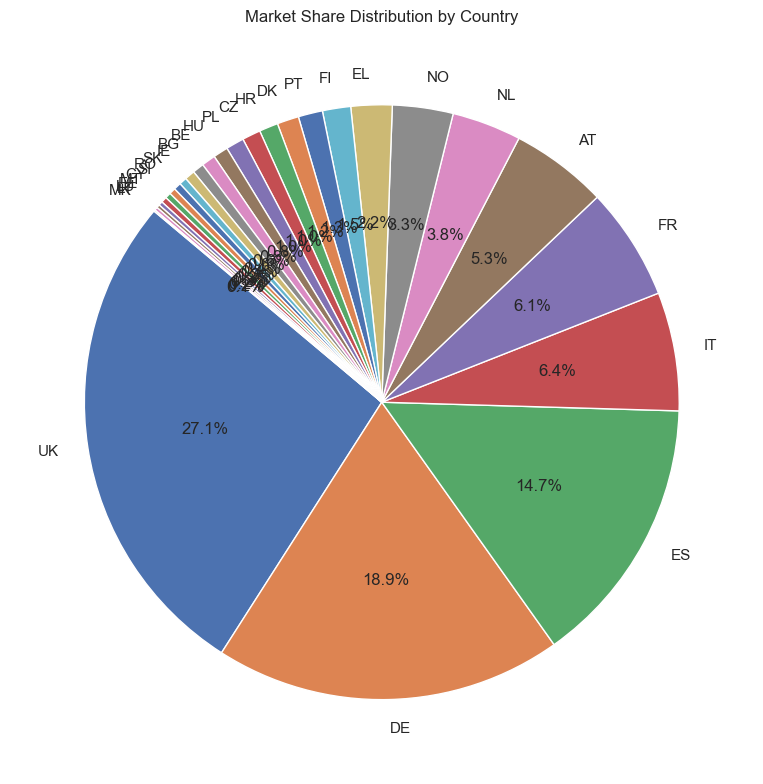

In [25]:
# Set Seaborn style
sns.set(style="whitegrid")

# Plot 1: Pie chart - Market share distribution
plt.figure(figsize=(8, 8))
plt.pie(df_sorted['Estimated Market Size'], labels=df_sorted['Country Code'], autopct='%1.1f%%', startangle=140)
plt.title('Market Share Distribution by Country')
plt.tight_layout()

# Save the plot to a file
plt.savefig('output_data/market_share_pie.png')

plt.show()

/var/folders/q0/31_jtg7s37n_nss3j1nn4_k00000gn/T/ipykernel_15968/3546890101.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_sorted.head(5), x='Country Code', y='Estimated Market Size', palette='viridis')


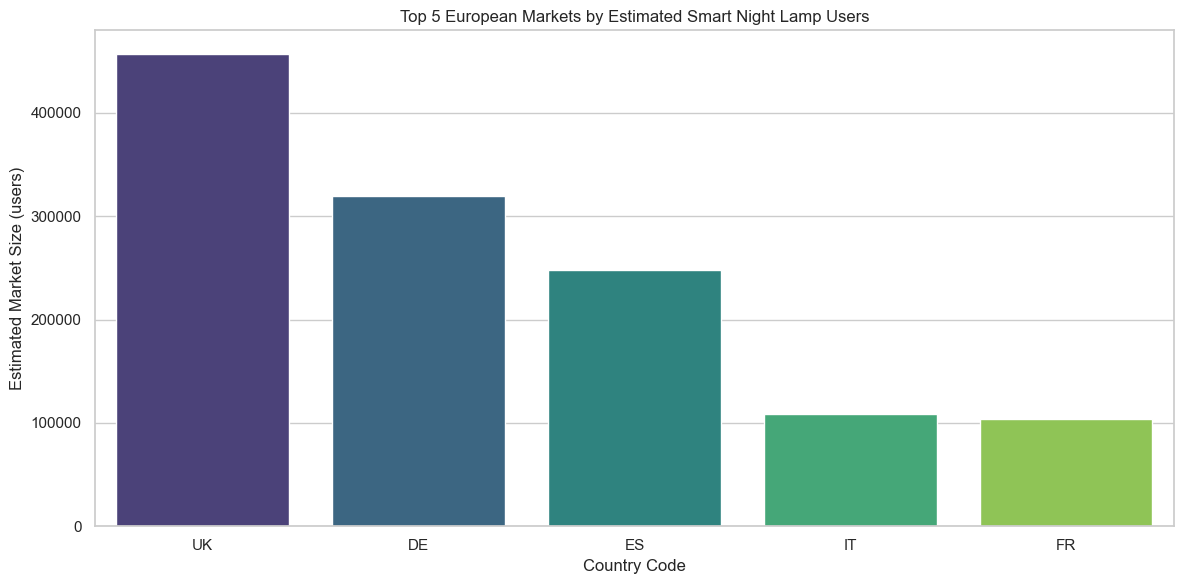

In [26]:
# Plot 1: Bar chart - Top 5 High-High markets
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_sorted.head(5), x='Country Code', y='Estimated Market Size', palette='viridis')
plt.title('Top 5 European Markets by Estimated Smart Night Lamp Users')
plt.ylabel('Estimated Market Size (users)')
plt.xlabel('Country Code')
plt.tight_layout()

# Save the plot to a file
plt.savefig('output_data/top_5_market_share_bar.png')

plt.show()


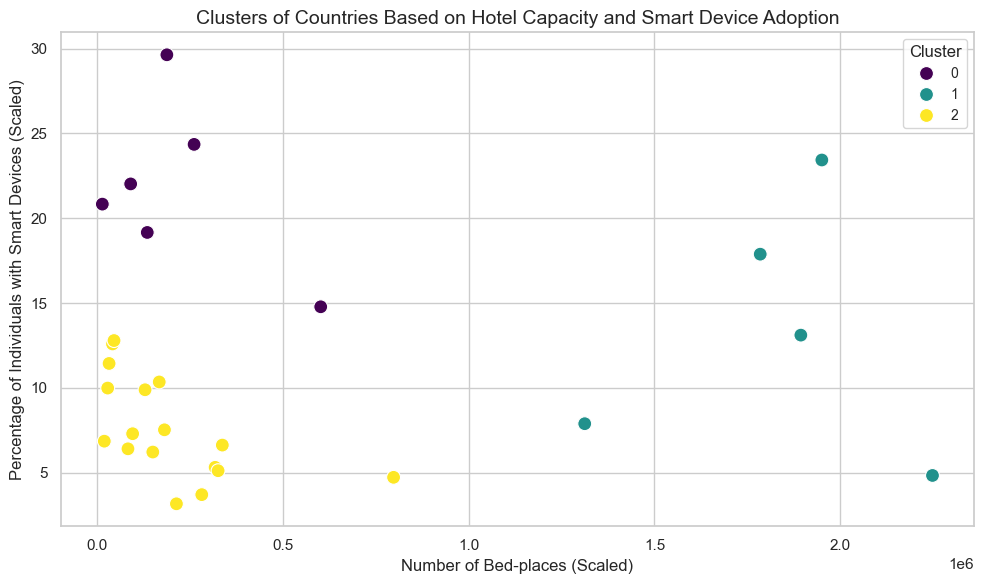

         Number of Bed-places  Percentage of individuals  \
Cluster                                                    
0                2.151657e+05                     21.795   
1                1.837943e+06                     13.430   
2                1.911394e+05                      7.650   

         Estimated Market Size  
Cluster                         
0                 42841.310717  
1                247351.105460  
2                 11491.158865  
Cluster 0: ['AT', 'DK', 'FI', 'LU', 'NL', 'NO']
Cluster 2: ['BE', 'BG', 'CY', 'CZ', 'EE', 'EL', 'HR', 'HU', 'IE', 'LT', 'MK', 'MT', 'PL', 'PT', 'RO', 'SI', 'SK']
Cluster 1: ['DE', 'ES', 'FR', 'IT', 'UK']
         Number of Bed-places  Percentage of individuals  \
Cluster                                                    
0                2.151657e+05                     21.795   
1                1.837943e+06                     13.430   
2                1.911394e+05                      7.650   

         Estimated Market Siz

In [30]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare the data for clustering
cluster_data = df[['Number of Bed-places', 'Percentage of individuals']]

# Scale the data
scaler = StandardScaler()
scaled_cluster_data = scaler.fit_transform(cluster_data)

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init = 'auto')  # You can adjust the number of clusters. I checked scattered plot and it had visible 3 clusters
df['Cluster'] = kmeans.fit_predict(scaled_cluster_data)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Number of Bed-places', y='Percentage of individuals',
                hue='Cluster', palette='viridis', s=100)
plt.title('Clusters of Countries Based on Hotel Capacity and Smart Device Adoption', fontsize=14)
plt.xlabel('Number of Bed-places (Scaled)', fontsize=12)
plt.ylabel('Percentage of Individuals with Smart Devices (Scaled)', fontsize=12)
plt.legend(title='Cluster', fontsize=10)
plt.tight_layout()

# Save the plot to a file
plt.savefig('output_data/market_clusters.png')

plt.show()

# Analyze the clusters
cluster_summary = df.groupby('Cluster')[['Number of Bed-places', 'Percentage of individuals', 'Estimated Market Size']].mean()
print(cluster_summary)

# Add cluster strategy
cluster_strategy = {
    0: 'High-High | Primary target for launch | High demand + high readiness for smart products',
    1: 'Low-Low | Avoid in initial phase | Risk of poor product-market fit',
    2: 'Low-High | Secondary target / R&D test bed | Useful for learning, but with limited commercial upside'
}

# Print countries in each cluster
for cluster in df['Cluster'].unique():
    countries = df[df['Cluster'] == cluster]['Country Code'].tolist()
    print(f"Cluster {cluster}: {countries}")

# Add strategy to cluster summary
cluster_summary['Strategy'] = cluster_summary.index.map(cluster_strategy)
print(cluster_summary)



1. High Bed-places – High Smart Adoption
🔑 Ideal Launch Markets

These countries have large hotel infrastructure and high smart tech adoption.
['DE', 'ES', 'FR', 'IT', 'UK']
Likely early adopters of smart hotel devices.

Good opportunity for high volume and ease of integration (guests already comfortable with smart devices).

📌 Action: Prioritize these markets for initial launch or pilot program.

2. Low Bed-places – Low Smart Adoption
⚠️ Least Ready Markets

Small tourism/hospitality sector and low tech engagement.
['AT', 'BE', 'BG', 'CY', 'CZ', 'EE', 'EL', 'HR', 'HU', 'IE', 'LT', 'LV', 'MK', 'MT', 'PL', 'PT', 'RO', 'SI', 'SK']
Launching here risks low adoption and low sales volume.

📌 Action: De-prioritize; revisit after gaining traction elsewhere.

3. Low Bed-places – High Smart Adoption
💡 Niche but Smart

Tech-savvy populations but small hotel industry.
['DK', 'FI', 'LU', 'NL', 'NO', 'SE']
Good for testing tech usability and reception, even if not scalable.

Might work well for boutique or luxury hotels aiming for premium guest experiences.

📌 Action: Consider for controlled experiments or premium positioning.